# Imports

In [203]:
#!pip install -U scikit-learn

In [204]:
from Transformation import Transformation
import numpy as np
import math
from sklearn import preprocessing
from sklearn.neighbors import NearestNeighbors
import networkx as nx

# Input

In [205]:
transformation = Transformation()

# Create objects
stl_file_path = "3d_models/stl/Handle.stl"
mesh_data = transformation.stl_to_mesh(stl_file_path)
graph = transformation.mesh_to_graph(mesh_data)

transformation.print_graph_properties(graph, display_graph=False, display_labels=False)

Number of nodes: 5999
Number of edges: 17991


In [206]:
print(graph._node)

{(75.0252, -0.66553295, 3.8): {'index_triangle': {0, 6820, 164, 165, 6821, 6822}}, (75.01418, -0.49935842, 16.7): {'index_triangle': {0, 1, 165, 370, 371, 372}}, (75.0, 0.0, 3.8): {'index_triangle': {0, 1, 2, 6658, 6659, 11415, 11416, 11417, 6822, 6823, 6824, 6825, 6826, 6827, 6828, 6829, 6830, 6831, 6832, 6833, 6834, 6835, 6836, 6837, 6838, 6839, 6840, 6841, 6842, 6843, 6844, 6845, 6846, 6847, 6848, 6849, 6850, 6851, 6852, 6853, 6854, 6855, 6856, 6857, 6858, 6859, 6860, 6861, 6862, 6863, 6864, 6865, 6866, 6867, 6868, 6869, 6870, 6871, 6872, 6873, 6874, 6875, 6876, 6877, 6878, 6495}}, (75.00158, 0.16653232, 16.7): {'index_triangle': {1, 2, 3, 372, 373, 374}}, (75.0252, 0.66553295, 3.8): {'index_triangle': {2, 6659, 3, 4, 6660}}, (75.03937, 0.8314692, 16.7): {'index_triangle': {3, 4, 5, 374, 375, 376}}, (75.10067, 1.3272538, 3.8): {'index_triangle': {6660, 6661, 4, 5, 6, 6662}}, (75.12734, 1.4916434, 16.7): {'index_triangle': {5, 6, 7, 376, 377, 378}}, (75.22596, 1.9813722, 3.8): {'inde

# Point Sampler

### DevConv

In [207]:
def relu(array):
    return np.maximum(array, 0)

def sigmoid(array):
    return 1 / (1 + np.exp(-array))

In [208]:
class DevConv():
    def __init__(self, graph, output_dimension):
        self.graph = graph
        self.list_node = list(graph._node)

        self.W_phi = np.random.random((output_dimension))      #change
        self.W_theta = np.array([0.2, 0.2, 0.2])  # change
    
    def forward(self, previous_inclusion_score, return_flatten=True):
        list_inc_score = np.zeros((len(self.list_node), len(self.W_phi)))
        for index_current_node, (current_node, dict_neigh) in enumerate(self.graph._adj.items()):
            # print(index_current_node, " | ", current_node, " | ", dict_neigh)
            neigh_distances = np.zeros(shape=len(dict_neigh))
            for index_neigh, neigh_node in enumerate(dict_neigh.keys()):
                neigh_distances[index_neigh] = np.linalg.norm(np.multiply(self.W_theta, np.array(current_node) - np.array(neigh_node))) # norm(W_theta * (xi - xj))
            list_inc_score[index_current_node] = self.W_phi * np.max(neigh_distances)                                   # W_phi * max(distance)    

        # return if no previous inclusion score
        if len(previous_inclusion_score)==0:
            if return_flatten:
                list_inc_score = list_inc_score.flatten()
            return list_inc_score
        
        # mean the rows if more than one column
        if list_inc_score.shape[1]!=1:
            list_inc_score = np.mean(list_inc_score, axis=1)

        # array of array to array
        if len(list_inc_score.shape)==2:
            if list_inc_score.shape[1]==1:
                list_inc_score = list_inc_score.flatten()

        # Return the mean of previous and current inclusion score
        return np.mean(np.array([previous_inclusion_score, list_inc_score], dtype=np.float64), axis=0)
        

In [209]:
devconv = DevConv(graph, 1)
inclusion_score = devconv.forward(previous_inclusion_score=np.array([]))
inclusion_score = relu(inclusion_score)
print(inclusion_score)

devconv = DevConv(graph, 64)
inclusion_score = devconv.forward(previous_inclusion_score=inclusion_score)
inclusion_score = relu(inclusion_score)
print(inclusion_score)

devconv = DevConv(graph, 1)
inclusion_score = devconv.forward(previous_inclusion_score=inclusion_score)
inclusion_score = sigmoid(inclusion_score)
print(inclusion_score)
print(inclusion_score.shape)

[0.48813694 0.48842094 0.48813693 ... 0.45443905 0.65965531 0.45443905]
[0.93353237 0.9340755  0.93353237 ... 0.8690872  1.26155088 0.8690872 ]
[0.7586704  0.75879239 0.7586704  ... 0.74389881 0.82460564 0.74389881]
(5999,)


### Multinomial Sampling

In [210]:
normalized_inclusion_score = inclusion_score / np.sum(inclusion_score)  # normalize for multinomial sampling
normalized_inclusion_score = np.round(normalized_inclusion_score, 8)    # round to remove float imprecision

number_throws = 500     # small:more randomness    |   big:less randomness
mult_sampling = np.random.multinomial(number_throws, normalized_inclusion_score)
print(mult_sampling)

[1 0 0 ... 0 0 0]


In [211]:
target_number_point = min(len(graph._node), 50)   # number of points for the simplification

index_k_nodes = np.argpartition(mult_sampling, -target_number_point)[-target_number_point:]
list_k_nodes = np.array(list(graph._node.keys()))[index_k_nodes]
list_k_nodes = [tuple(e) for e in list_k_nodes]
print(list_k_nodes)

[(85.85287, -4.7321377, -8.253332), (75.97639, -4.4479885, 81.909386), (76.89767, -5.5423326, 81.70848), (92.58582, -0.49935842, 29.6), (75.37597, -6.0434117, 83.57376), (78.55411, -2.9401166, -12.920766), (91.44655, -2.3044074, -1.5438064), (90.408104, -2.3044074, -4.050822), (89.34233, -6.8353896, 29.6), (89.97611, -2.3044074, -4.8464603), (75.59852, -6.5098743, 84.015816), (76.312546, -5.0095077, 2.9476252), (75.03608, 1.3272538, 81.29398), (76.48843, -5.0095077, 3.31638), (76.03164, -6.5098743, 83.88752), (85.88279, -2.3044074, -9.639124), (77.03556, -6.5098743, 83.235565), (77.73782, -6.5098743, 82.08958), (90.54172, -1.6554987, -4.1189003), (76.69401, -6.9390492, 84.13411), (76.96415, -7.328478, 84.60201), (77.47216, -7.328478, 84.25287), (78.84246, -7.328478, 82.01674), (75.47001, -7.6759295, 85.67187), (85.34132, -0.33300498, -10.433599), (84.582214, -0.33300498, -10.955316), (83.79685, -0.33300498, -11.436588), (91.914116, 3.4060426, 42.5), (81.886826, -8.535009, 89.70452), (9

# KNN

In [212]:
XYZ = [list(e) for e in list_k_nodes]
print(XYZ)

[[85.85287, -4.7321377, -8.253332], [75.97639, -4.4479885, 81.909386], [76.89767, -5.5423326, 81.70848], [92.58582, -0.49935842, 29.6], [75.37597, -6.0434117, 83.57376], [78.55411, -2.9401166, -12.920766], [91.44655, -2.3044074, -1.5438064], [90.408104, -2.3044074, -4.050822], [89.34233, -6.8353896, 29.6], [89.97611, -2.3044074, -4.8464603], [75.59852, -6.5098743, 84.015816], [76.312546, -5.0095077, 2.9476252], [75.03608, 1.3272538, 81.29398], [76.48843, -5.0095077, 3.31638], [76.03164, -6.5098743, 83.88752], [85.88279, -2.3044074, -9.639124], [77.03556, -6.5098743, 83.235565], [77.73782, -6.5098743, 82.08958], [90.54172, -1.6554987, -4.1189003], [76.69401, -6.9390492, 84.13411], [76.96415, -7.328478, 84.60201], [77.47216, -7.328478, 84.25287], [78.84246, -7.328478, 82.01674], [75.47001, -7.6759295, 85.67187], [85.34132, -0.33300498, -10.433599], [84.582214, -0.33300498, -10.955316], [83.79685, -0.33300498, -11.436588], [91.914116, 3.4060426, 42.5], [81.886826, -8.535009, 89.70452], [9

In [213]:
def connect_extended_graph(XYZ, number_neigh=3):
    is_graph_connected = False
    while not is_graph_connected:
        # Create the nearest neighbors object
        _, indices = NearestNeighbors(n_neighbors=number_neigh).fit(XYZ).kneighbors(XYZ)
        # Create the graph from the nearest points
        extended_graph = nx.Graph()
        for index_poly, poly in enumerate(indices):
            for index_current_node in range(len(poly)):
                current_node = list_k_nodes[poly[index_current_node]]
                for index_other_node in range(index_current_node+1, len(poly)):
                    edge = current_node, list_k_nodes[poly[index_other_node]]
                    extended_graph.add_edge(*edge)
                    # if attribute do not exists
                    if len(extended_graph.nodes[current_node])==0:
                        extended_graph.nodes[current_node]['index_poly'] = set()
                    extended_graph.nodes[current_node]['index_poly'].add(index_poly)
        is_graph_connected = nx.is_connected(extended_graph)
        number_neigh += 1
    print("Number of neighbors : ", number_neigh-1)
    return extended_graph

In [214]:
extended_graph = connect_extended_graph(XYZ)

Number of neighbors :  5


Number of nodes: 50
Number of edges: 185


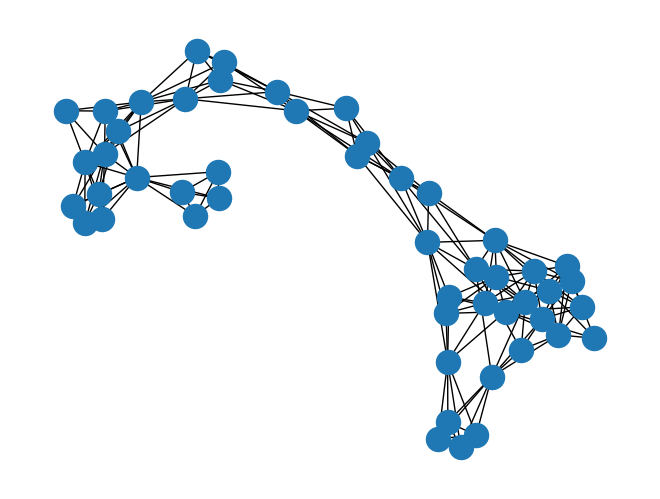

In [215]:
transformation.print_graph_properties(graph=extended_graph, display_graph=True, display_labels=False)

# Edge Predictor

In [216]:
devconv = DevConv(extended_graph, 64)
inclusion_score = devconv.forward(previous_inclusion_score=np.array([]), return_flatten=False)
print(inclusion_score.shape)

(50, 64)


In [217]:
"""
inclusion_score = [[f_1_1  , f_1_2  , ..., f_63_1  ],
                    ...,
                   [f_1_M-1, f_1_M-1, ..., f_63_M-1]]
M = number of points
64 = hidden dimensions
"""
from numpy import mean

#construction du fi
# fi = np.random.randint(100, size=(50, 1))
# for n in range(np.size(inclusion_score,0)):
#     fi[i] = np.mean(inclusion_score[i][:])
    
# fj = np.random.randint(100, size=(50, 1))
# for m in range(np.size(inclusion_score,0)):
#     fj[i] = np.mean(inclusion_score[i][:])

f = np.random.rand(50)


# f1i = np.mean(inclusion_score)
# f1j = np.mean(inclusion_score)

S = np.random.rand(50, 50)
wq = np.random.rand(64)
wk = np.random.rand(64)

In [218]:
for i in range(np.size(f,0)):
    for j in range(np.size(f, 0)): 
        f[i] = np.mean(inclusion_score[i][:])
        #print("f[",i,"] : " , f[i])
        f[j] = np.mean(inclusion_score[j][:])
        #print("f[",j,"] : " , f[j])
        wq_fi = wq*f[i].transpose()
        #print("wq_fi : " , wq_fi.transpose())
        wk_fj = wk*f[j]
        #print("wk_fj : " , wk_fj)
        wq_wk = np.matmul(wk_fj, wq_fi)
        #print("wq_wk : " , wq_wk)
        sum_wq_wk = 0
        for k in range(np.size(f, 0)):
            f[k] = np.mean(inclusion_score[k][:])
            #print("f[",k,"]",f[k])
            
            #print("wk*f[",k,"] * wq_fi = ",np.matmul(wk*f[k],wq_fi))
            #print("exp : " ,np.exp(np.matmul(wk*f[k],wq_fi))) #ça marche mais faut réduire les valeurs c'est trop grand
            sum_wq_wk += np.exp(np.matmul(wk*f[k],wq_fi))
            #print("somme : " , sum_wq_wk)
        print ("exp(wq_wk) :" , np.exp(wq_wk)) #error exp( ) vaut inf & overflow error
        print("somme : ", sum_wq_wk)
        S[i][j] = np.exp(wq_wk)/sum_wq_wk
        print("S[",i,"][",j,"] :" , S[i][j])


exp(wq_wk) : 1252798335949.59
somme :  2.6688655799792973e+30
S[ 0 ][ 0 ] : 4.694123021210038e-19
exp(wq_wk) : 15514105086.205732
somme :  2.6688655799792973e+30
S[ 0 ][ 1 ] : 5.8129960544232716e-21
exp(wq_wk) : 46335100.415713854
somme :  2.6688655799792973e+30
S[ 0 ][ 2 ] : 1.736134661981488e-23
exp(wq_wk) : 30087336.797988545
somme :  2.6688655799792973e+30
S[ 0 ][ 3 ] : 1.1273455292649822e-23
exp(wq_wk) : 21934386.2259837
somme :  2.6688655799792973e+30
S[ 0 ][ 4 ] : 8.2186178241895e-24
exp(wq_wk) : 641249.843061067
somme :  2.6688655799792973e+30
S[ 0 ][ 5 ] : 2.4027056584320044e-25
exp(wq_wk) : 621772.6325919691
somme :  2.6688655799792973e+30
S[ 0 ][ 6 ] : 2.3297262974060773e-25
exp(wq_wk) : 5.9400055889337496e+29
somme :  2.6688655799792973e+30
S[ 0 ][ 7 ] : 0.222566682769382
exp(wq_wk) : 4.275103742137238e+29
somme :  2.6688655799792973e+30
S[ 0 ][ 8 ] : 0.16018430355605998
exp(wq_wk) : 5997.104711869064
somme :  2.6688655799792973e+30
S[ 0 ][ 9 ] : 2.2470613570263004e-27
exp(

exp(wq_wk) : 58802.21502185134
somme :  5.506962148853748e+25
S[ 1 ][ 23 ] : 1.067779538562668e-21
exp(wq_wk) : 10490.891193387426
somme :  5.506962148853748e+25
S[ 1 ][ 24 ] : 1.9050232977488437e-22
exp(wq_wk) : 6420444326876.742
somme :  5.506962148853748e+25
S[ 1 ][ 25 ] : 1.165877693242023e-13
exp(wq_wk) : 11706721057951.45
somme :  5.506962148853748e+25
S[ 1 ][ 26 ] : 2.1258037991759495e-13
exp(wq_wk) : 13977066146.738445
somme :  5.506962148853748e+25
S[ 1 ][ 27 ] : 2.5380719476431695e-16
exp(wq_wk) : 9.041613019097278e+21
somme :  5.506962148853748e+25
S[ 1 ][ 28 ] : 0.00016418513101600405
exp(wq_wk) : 786519575.4139978
somme :  5.506962148853748e+25
S[ 1 ][ 29 ] : 1.4282276764471837e-17
exp(wq_wk) : 572499306464.6417
somme :  5.506962148853748e+25
S[ 1 ][ 30 ] : 1.0395918675123001e-14
exp(wq_wk) : 901803006.5731518
somme :  5.506962148853748e+25
S[ 1 ][ 31 ] : 1.6375689212987572e-17
exp(wq_wk) : 10942877.446446083
somme :  5.506962148853748e+25
S[ 1 ][ 32 ] : 1.9870987217015462

### Sparse Attention

# Face Candidates

# Face Classifier

### TriConv

# Simplified Mesh